# DATA-IQ TUTORIAL: PYTORCH STYLE API

In [1]:
import sys
sys.path.insert(0, "../")

# Imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Imports

In [2]:
from demo_data import load_adult_data
from data_iq.dataiq_class import DataIQ_Torch


## Get demo public dataset: Adult

In [3]:
from sklearn import preprocessing

X_train, X_test, y_train, y_test, X, y = load_adult_data(split_size=0.3)

# Pre-processing & normalization
X_train = X_train.to_numpy().astype(np.float32)
y_train = y_train.values.astype(np.float32)
X_test = X_test.to_numpy().astype(np.float32)
y_test = y_test.values.astype(np.float32)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# Get data ready for pytorch

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset


class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)


BATCH_SIZE = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


# INTIALIZE TORCH MODEL

In [5]:
class Example_NN(nn.Module):
    def __init__(self, input_size=12, num_units=64, nonlin=F.relu, nlabels=2):
        super(Example_NN, self).__init__()

        self.dense0 = nn.Linear(input_size, num_units)
        self.dense1 = nn.Linear(num_units, 32)
        self.dense2 = nn.Linear(32, 16)
        self.dense3 = nn.Linear(16, 8)
        self.nonlin = nonlin
        self.output = nn.Linear(8, nlabels)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = F.relu(self.dense2(X))
        X = F.relu(self.dense3(X))
        X = F.softmax(self.output(X))
        return X


# MODEL PARAMETERS

In [6]:
LEARNING_RATE = 0.01
EPOCHS = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Init model
net = Example_NN(input_size=X_train.shape[1], nlabels=len(np.unique(y_train)))
net.to(device)

n_feats = X_train.shape[1]
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
sf = nn.LogSoftmax()
criterion = torch.nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)


# INITIALIZE DATA-IQ

In [7]:
dataiq = DataIQ_Torch(X=X_train, y=y_train, sparse_labels=True)


# TRAIN LOOP: CALL DATA-IQ AT THE END OF EVERY EPOCH

In [8]:
for e in range(1, EPOCHS + 1):
    net.train()
    epoch_loss = 0
    epoch_acc = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        y_pred = net(X_batch)
        _, predicted = torch.max(y_pred.data, 1)

        y_batch = y_batch.to(torch.int64)

        loss = criterion(sf(y_pred), y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += (predicted == y_batch).sum().item() / len(y_batch)

    print(
        f"Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}"
    )

    ################################################################################################
    #
    # CALL DATA-IQ on EPOCH END
    #
    ################################################################################################
    dataiq.on_epoch_end(net, device=device)


/Users/nabeel/Documents/GitHub/Data-IQ/dataiq_env_test/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/nabeel/Documents/GitHub/Data-IQ/dataiq_env_test/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Epoch 001: | Loss: 0.52582 | Acc: 0.775


/Users/nabeel/Documents/GitHub/Data-IQ/dataiq_env_test/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 002: | Loss: 0.50365 | Acc: 0.796
Epoch 003: | Loss: 0.50248 | Acc: 0.794
Epoch 004: | Loss: 0.50124 | Acc: 0.799
Epoch 005: | Loss: 0.49961 | Acc: 0.799
Epoch 006: | Loss: 0.49875 | Acc: 0.801
Epoch 007: | Loss: 0.49869 | Acc: 0.799
Epoch 008: | Loss: 0.49911 | Acc: 0.799
Epoch 009: | Loss: 0.49772 | Acc: 0.802
Epoch 010: | Loss: 0.49688 | Acc: 0.803


# ACCESS METRICS

#### Aleatoric uncertainty via: `dataiq.aleatoric`
#### Variability via: `dataiq.variability`
#### Predictive confidence via: `dataiq.confidence`
#### Entropy via: `dataiq.entropy`
#### Mutual information via: `dataiq.mi`
#### Correctness over training via: `dataiq.correctness`

In [9]:
aleatoric_uncertainty = dataiq.aleatoric
confidence = dataiq.confidence


# PLOT DATA-IQ Characteristic curve:
### X-AXIS: ALEATORIC UNCERTAINTY
### Y-AXIS: PREDICTIVE CONFIDENCE

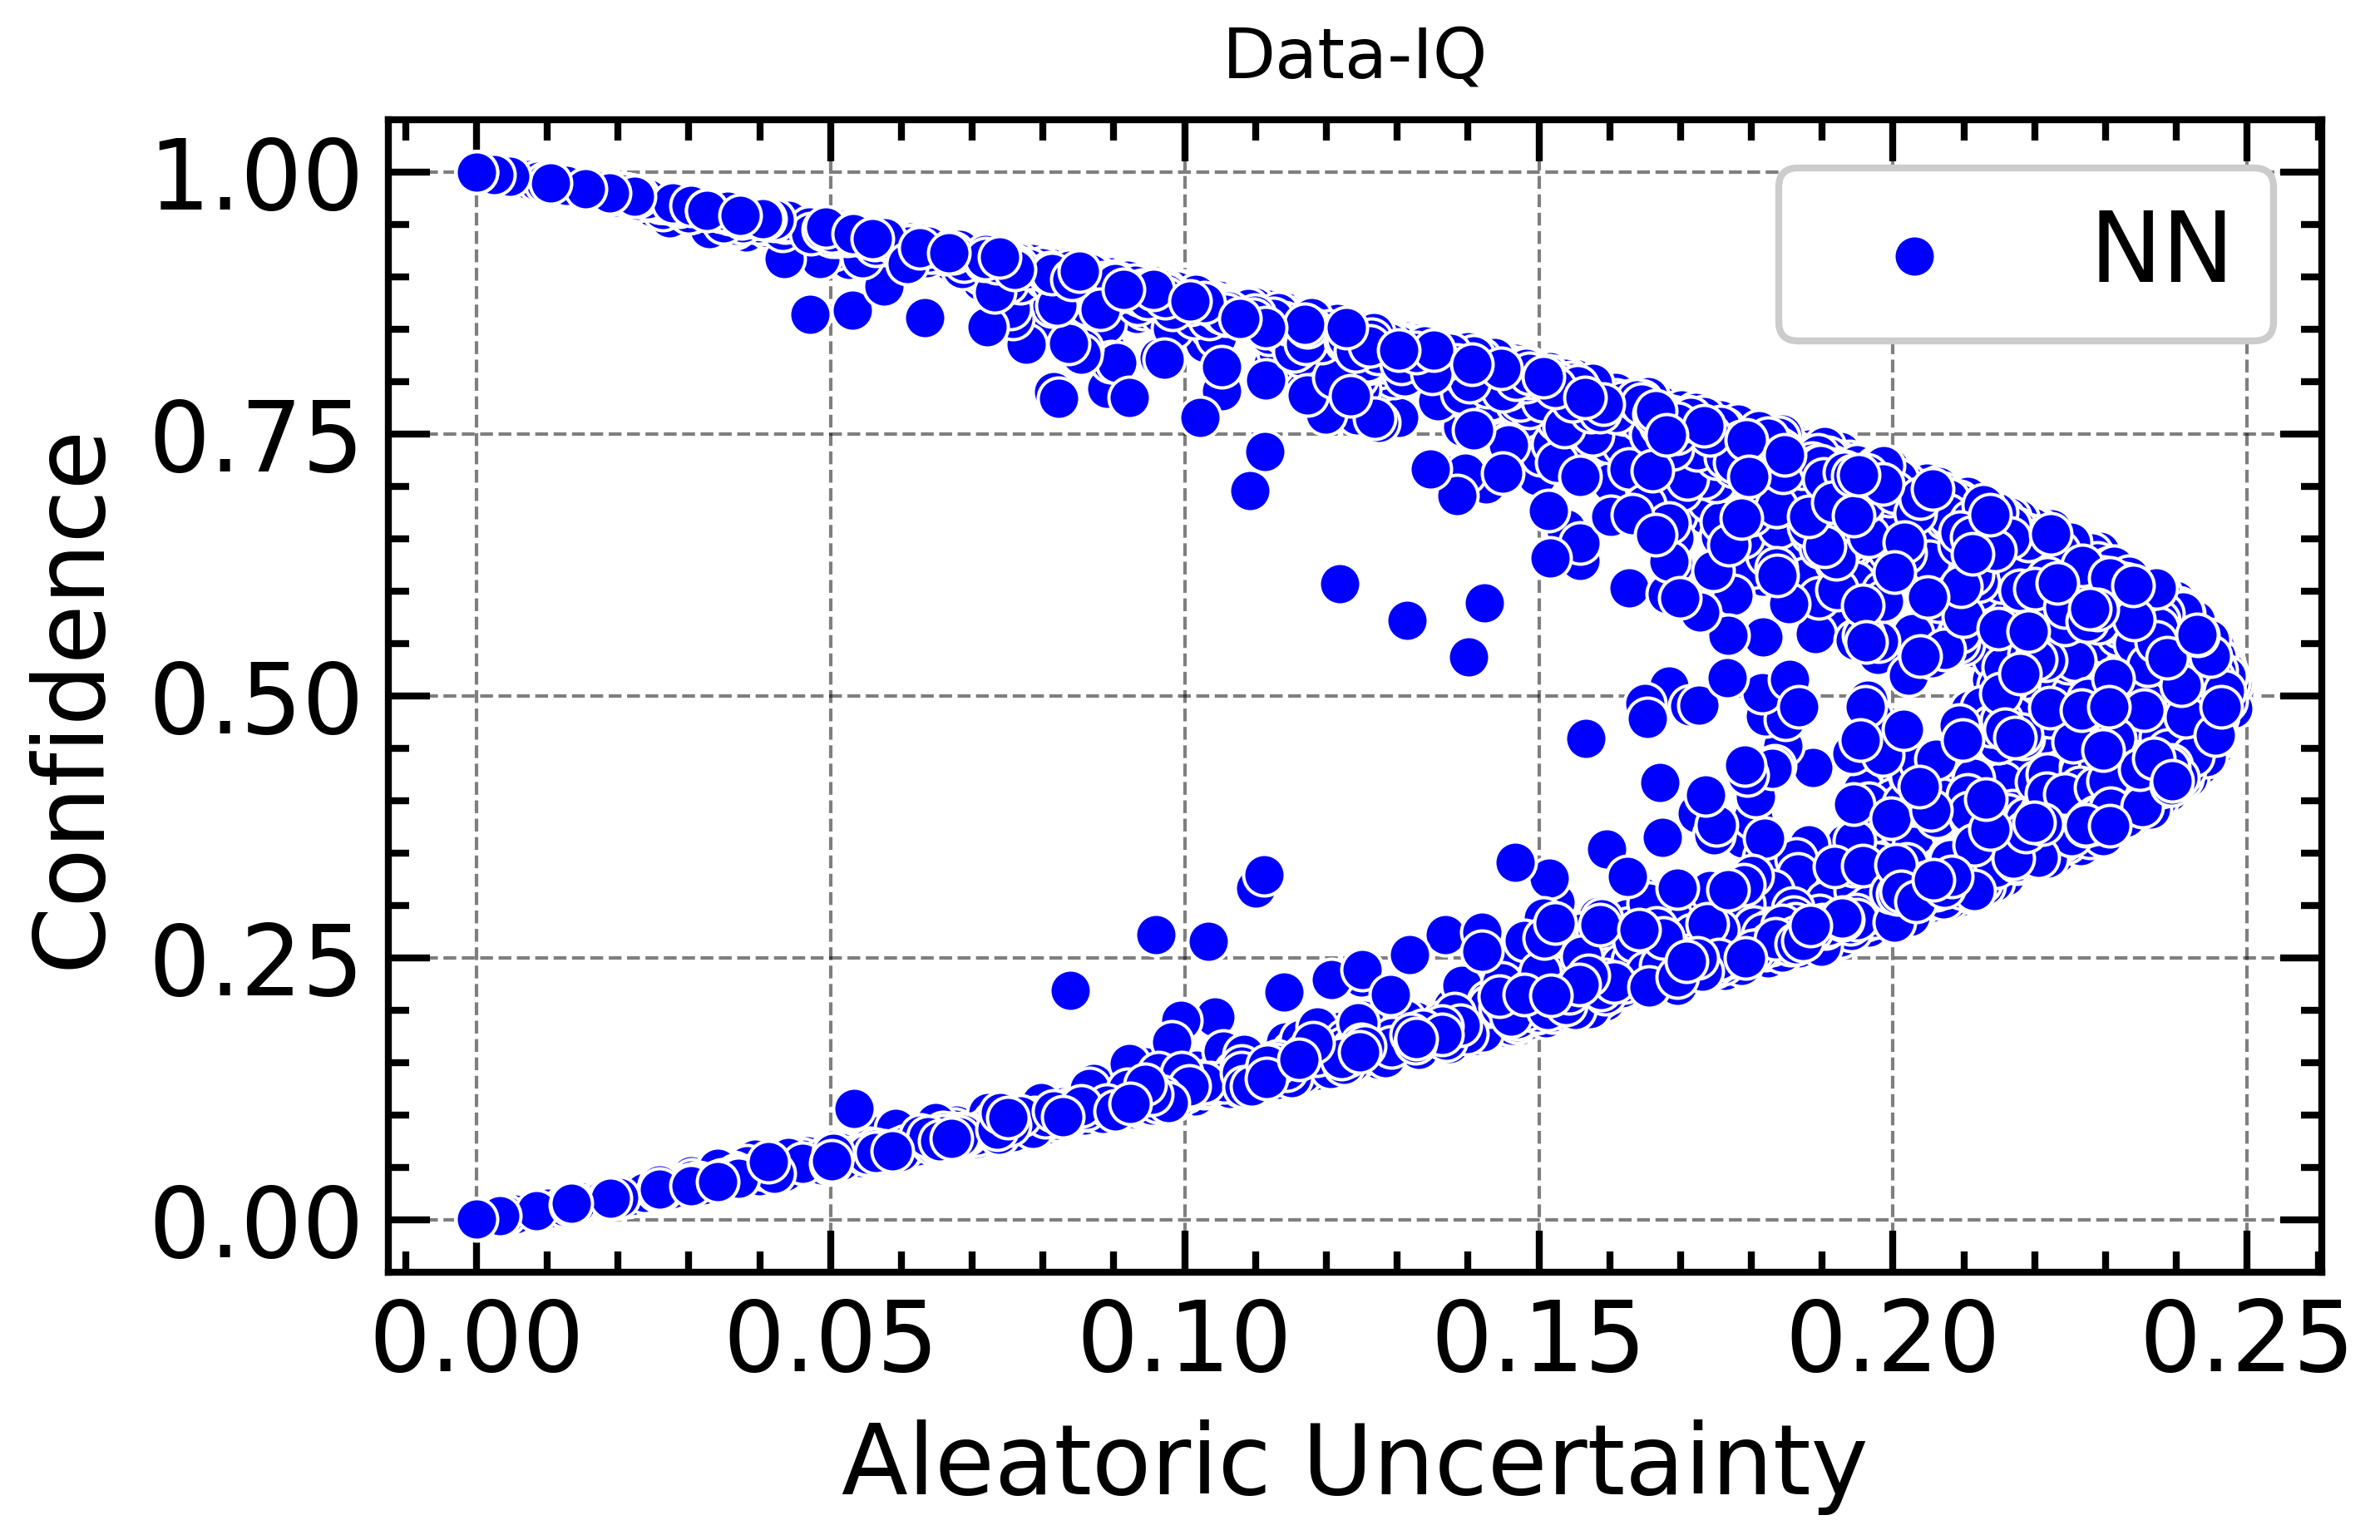

In [10]:
plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])
SMALL_SIZE = 10
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=14)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

# DATA-IQ
plt.figure(figsize=(5, 3))

aleatoric_uncertainty = dataiq.aleatoric
confidence = dataiq.confidence

sns.scatterplot(x=aleatoric_uncertainty, y=confidence, color="b", label="NN")

plt.title("Data-IQ")
plt.xlabel("Aleatoric Uncertainty")
plt.ylabel("Confidence")
plt.show()


# HOW TO STRATIFY SAMPLES

### DEFINE THRESHOLDS: THESE CAN BE ADAPTED PER USE-CASE

In [11]:
percentile_thresh = 50
thresh = 0.25
conf_thresh_low = thresh
conf_thresh_high = 1 - thresh
conf_thresh = 0.5

hard_train = np.where(
    (confidence <= conf_thresh_low)
    & (aleatoric_uncertainty <= np.percentile(aleatoric_uncertainty, percentile_thresh))
)[0]
easy_train = np.where(
    (confidence >= conf_thresh_high)
    & (aleatoric_uncertainty <= np.percentile(aleatoric_uncertainty, percentile_thresh))
)[0]

hard_easy = np.concatenate((hard_train, easy_train))
ambig_train = []
for id in range(len(confidence)):
    if id not in hard_easy:
        ambig_train.append(id)

ambig_train = np.array(ambig_train)


In [12]:
len(easy_train), len(ambig_train), len(hard_train)

(6672, 7133, 461)